In [1]:
import sys
sys.path.append('/cellar/users/zkoch/methylation_and_mutation/source_files')
%load_ext autoreload
%aimport mutation_features, methylation_pred, somatic_mut_clock, methylation_motifs
%autoreload 1
import get_data, utils, mutation_features, methylation_pred, somatic_mut_clock

/cellar/users/zkoch/miniconda3/envs/tf_env/lib/python3.10/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/cellar/users/zkoch/miniconda3/envs/tf_env/lib/python3.10/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
 

In [2]:
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import dask.dataframe as dd
from scipy.stats import spearmanr, pearsonr
from scipy import stats
import dask
import sklearn
from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV
import xgboost as xgb
import shap
from pymemesuite.common import MotifFile
import Bio.SeqIO
from pymemesuite.common import Sequence
from pymemesuite.fimo import FIMO


%config InlineBackend.figure_format = 'retina'
plt.style.use("seaborn-deep")
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.


# TCGA Data

In [3]:
# qnorm data
all_mut_w_age_df, illumina_cpg_locs_df, all_methyl_age_df_t, matrix_qtl_dir, covariate_fn = get_data.read_tcga_data()

reading in data
Got mutations and metadata, reading methylation
Converting Dask df to pandas df, takes ~10min
Got methylation, transposing
Done


In [4]:
mut_feat_tcga_dict = {}
somage_tcga_dict = {}

# for each cv iteration
for cv_num in [0]:
    # create a mutation features object
    mut_feat_tcga = mutation_features.mutationFeatures(
        all_mut_w_age_df = all_mut_w_age_df, illumina_cpg_locs_df = illumina_cpg_locs_df, 
        all_methyl_age_df_t = all_methyl_age_df_t, out_dir = "./", 
        consortium = 'TCGA', dataset = '', cross_val_num = cv_num,
        matrix_qtl_dir = matrix_qtl_dir,
        covariate_fn = covariate_fn, motif_occurence_df = pd.DataFrame()
    )
    # add to dictionary
    mut_feat_tcga_dict[cv_num] = mut_feat_tcga
    # and create a somage object from the seperate somage outputs
    somage_tcga = somatic_mut_clock.mutationClock.construct_from_paths(
        somage_path = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/071823_tcga_somage_output",
        directory_glob = f"TCGA__500correl_0meqtl_50000nearby_Bothagg_1000numCpGs_*startTopCpGs_500extendAmount_{cv_num}crossValNum",
        file_suffix = "xgboost_nonebaseline_agg_only",
        mut_feat = mut_feat_tcga,
        illumina_cpg_locs_df = illumina_cpg_locs_df,
        all_methyl_age_df_t = all_methyl_age_df_t,
        out_dir = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/071823_tcga_somage_output"
        )
    # read in pre-comp prediction performance by dset
    #somage_tcga.performance_by_dataset_df = pd.read_parquet(f"/cellar/users/zkoch/methylation_and_mutation/output_dirs/062623_tcga_somage_output/pred_methyl_and_perf_by_dset/performance_by_dataset_CV{cv_num}.parquet")
    # add to dictionary
    somage_tcga_dict[cv_num] = somage_tcga

Creating soMage object


In [5]:
somage_scramble_tcga_dict = {}

# for each cv iteration
for cv_num in [0]:
    # and create a somage object from the seperate somage outputs
    somage_scramble_tcga = somatic_mut_clock.mutationClock.construct_from_paths(
        somage_path = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/071823_tcga_somage_output",
        directory_glob = f"TCGA__500correl_0meqtl_50000nearby_Bothagg_1000numCpGs_*startTopCpGs_500extendAmount_{cv_num}crossValNum",
        file_suffix = "xgboost_scramblebaseline_agg_only",
        mut_feat = mut_feat_tcga,
        illumina_cpg_locs_df = illumina_cpg_locs_df,
        all_methyl_age_df_t = all_methyl_age_df_t,
        out_dir = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/071823_tcga_somage_output"
        )
    # read in pre-comp prediction performance by dset
    #somage_tcga.performance_by_dataset_df = pd.read_parquet(f"/cellar/users/zkoch/methylation_and_mutation/output_dirs/062623_tcga_somage_output/pred_methyl_and_perf_by_dset/performance_by_dataset_CV{cv_num}.parquet")
    # add to dictionary
    somage_scramble_tcga_dict[cv_num] = somage_scramble_tcga

Creating soMage object


Loading performance data: 100%|██████████| 136/136 [00:05<00:00, 23.93it/s]


#### Prediction performance

In [8]:
somage_scramble_tcga_dict[0].performance_by_dataset_df['Type'] = 'Scrambled'
somage_tcga_dict[0].performance_by_dataset_df['Type'] = 'soMage'
all_perf_by_dset_df = pd.concat([somage_scramble_tcga_dict[0].performance_by_dataset_df, somage_tcga_dict[0].performance_by_dataset_df])
all_perf_by_dset_df.reset_index(drop=True, inplace = True)


In [34]:
grouped_perf_df = all_perf_by_dset_df.groupby(['dataset', 'Type'])['AvP_methyl_pearson'].describe()
# subtract each pair of rows of the same dataset
somage_minus_scrambled_df = pd.DataFrame(grouped_perf_df.query("Type == 'soMage'")[['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']].values - grouped_perf_df.query("Type == 'Scrambled'")[['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']].values, columns = ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'], index = grouped_perf_df.query("Type == 'soMage'").index.get_level_values(0))
                                         
somage_minus_scrambled_df.sort_values(by = '75%', ascending = False, inplace = True)
somage_minus_scrambled_df

,count,mean,std,min,25%,50%,75%,max
dataset,,,,,,,,
STAD,482.0,0.068162,0.014727,0.028424,0.053581,0.055357,0.072945,4.351287e-04
COAD,424.0,0.046356,0.000041,0.034799,0.045658,0.033762,0.040436,-4.898844e-03
UCEC,4887.0,0.036130,-0.001811,0.118628,0.036405,0.031229,0.033997,-1.337118e-02
SKCM,525.0,0.025945,0.007277,0.099245,0.021038,0.018385,0.026345,9.598510e-03
LUAD,604.0,0.025469,0.005660,0.105520,0.020748,0.018135,0.023709,1.352704e-02
ESCA,5033.0,0.015832,0.006128,-0.002504,0.013202,0.011886,0.015663,-2.829717e-03
PRAD,31897.0,0.016610,-0.001657,0.005450,0.014534,0.010273,0.013077,2.386775e-03
BLCA,623.0,0.016306,0.000864,0.025901,0.017716,0.011139,0.012935,2.327419e-03
LUSC,783.0,0.008033,0.003960,0.033843,0.005851,0.000559,0.006319,-5.479251e-03


<Axes: xlabel='AvP_methyl_pearson', ylabel='Count'>

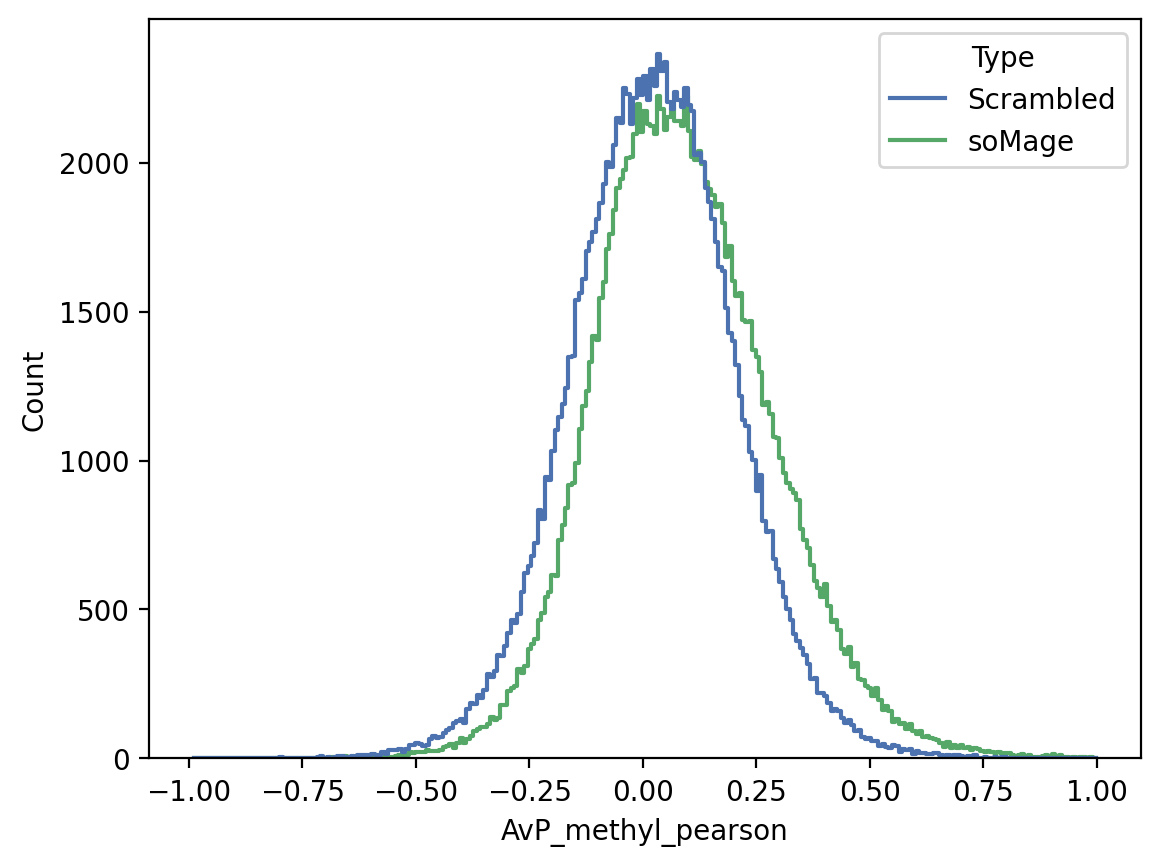

In [43]:
sns.histplot(data = all_perf_by_dset_df.query("dataset == 'STAD'"), x = 'AvP_methyl_pearson', hue = 'Type', element="step", fill=False, stat='count', common_norm=False)

In [74]:
all_perf_by_dset_df.query("dataset == 'STAD' and Type == 'soMage' and train_Amethyl_v_Age_pearson_abs > 0.2").sort_values(by="Pmethyl_v_Age_pearson_abs", ascending=False)

,AvP_methyl_pearson,Pmethyl_v_Age_pearson_abs,train_AvP_methyl_pearson,train_Amethyl_v_Age_pearson_abs,dataset,cpg,Type
4580703,0.356298,0.533809,0.347715,0.207480,STAD,cg01355739,soMage
3186603,0.247819,0.524752,0.366447,0.272030,STAD,cg01664864,soMage
4546623,0.288895,0.498623,0.293329,0.240405,STAD,cg19130973,soMage
2761063,0.198687,0.490984,0.386862,0.219108,STAD,cg20028827,soMage
2812463,0.358685,0.484541,0.308862,0.211409,STAD,cg13615963,soMage
...,...,...,...,...,...,...,...
4002953,-0.050749,0.002186,0.401696,0.203740,STAD,cg04863758,soMage
4189886,0.111221,0.001624,0.315420,0.257246,STAD,cg02716646,soMage
3492644,0.070353,0.000918,0.416026,0.209217,STAD,cg00603340,soMage
2778001,0.278538,0.000741,0.392408,0.244292,STAD,cg14231297,soMage


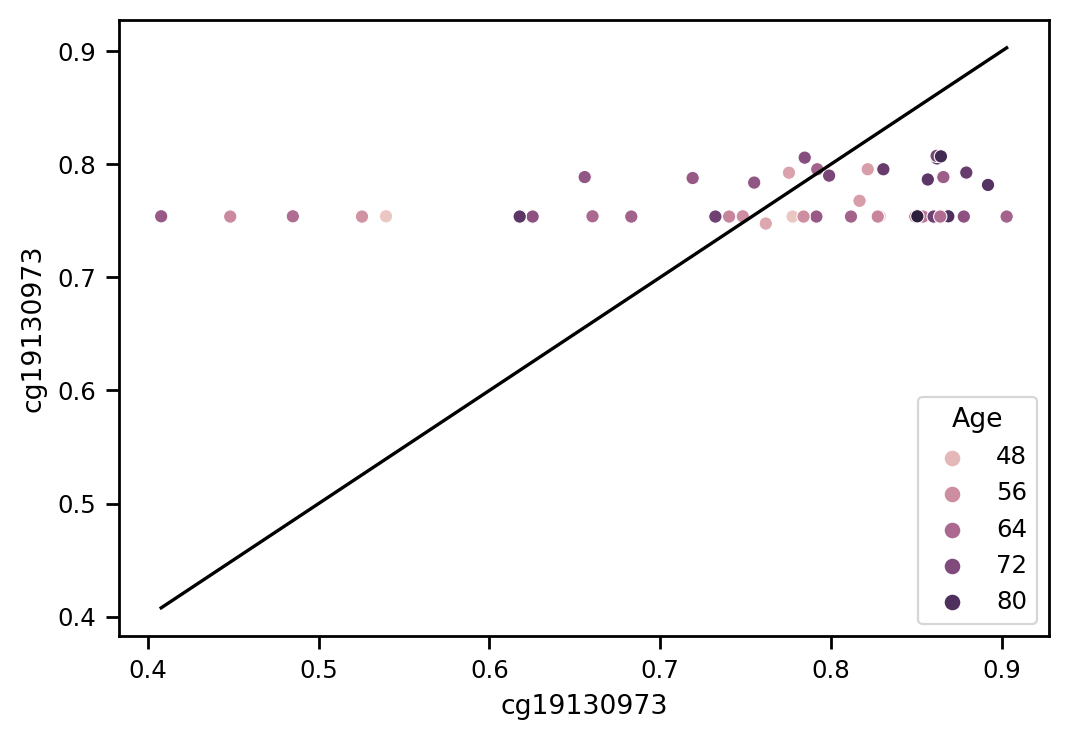

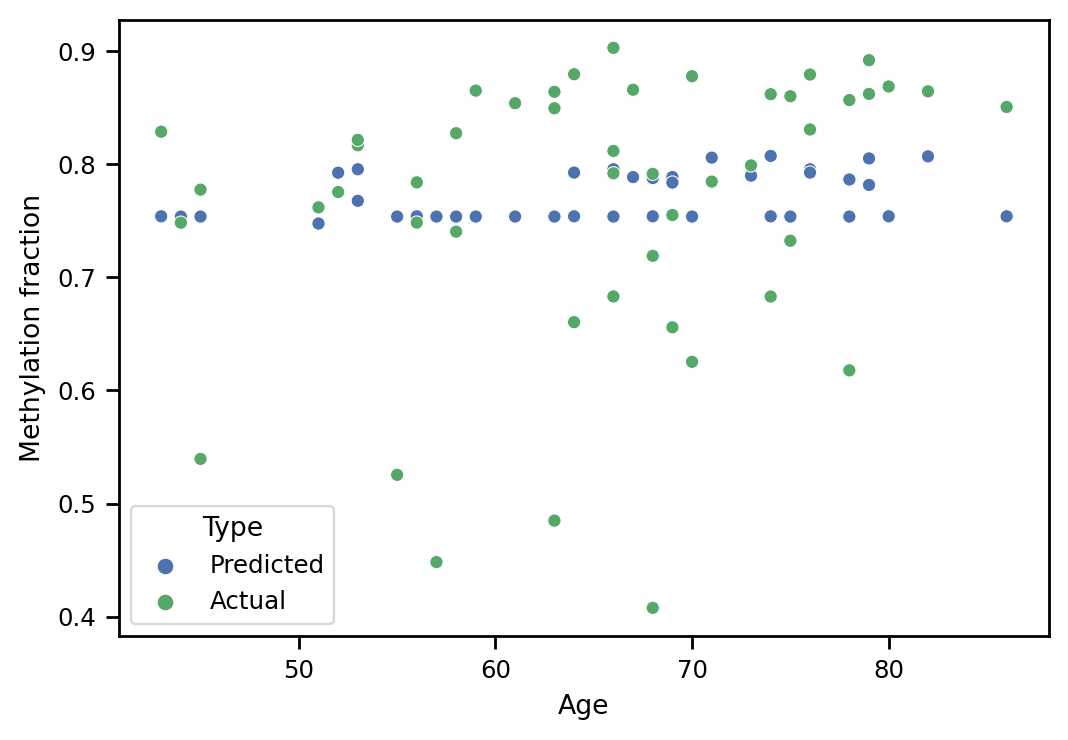

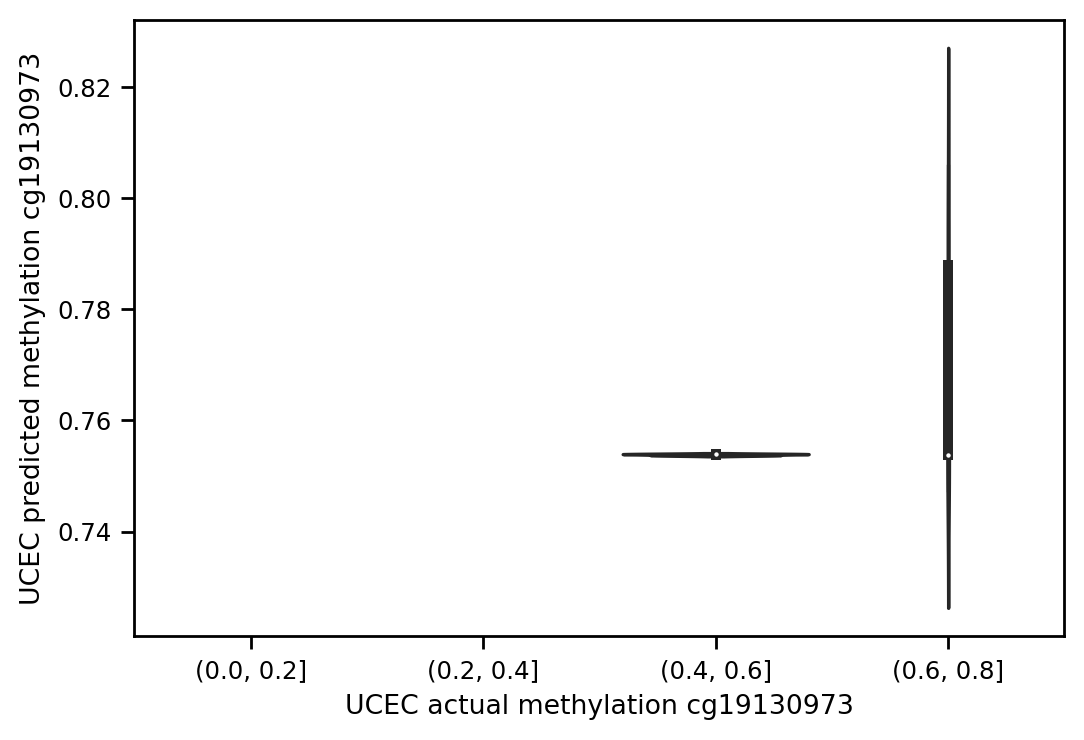

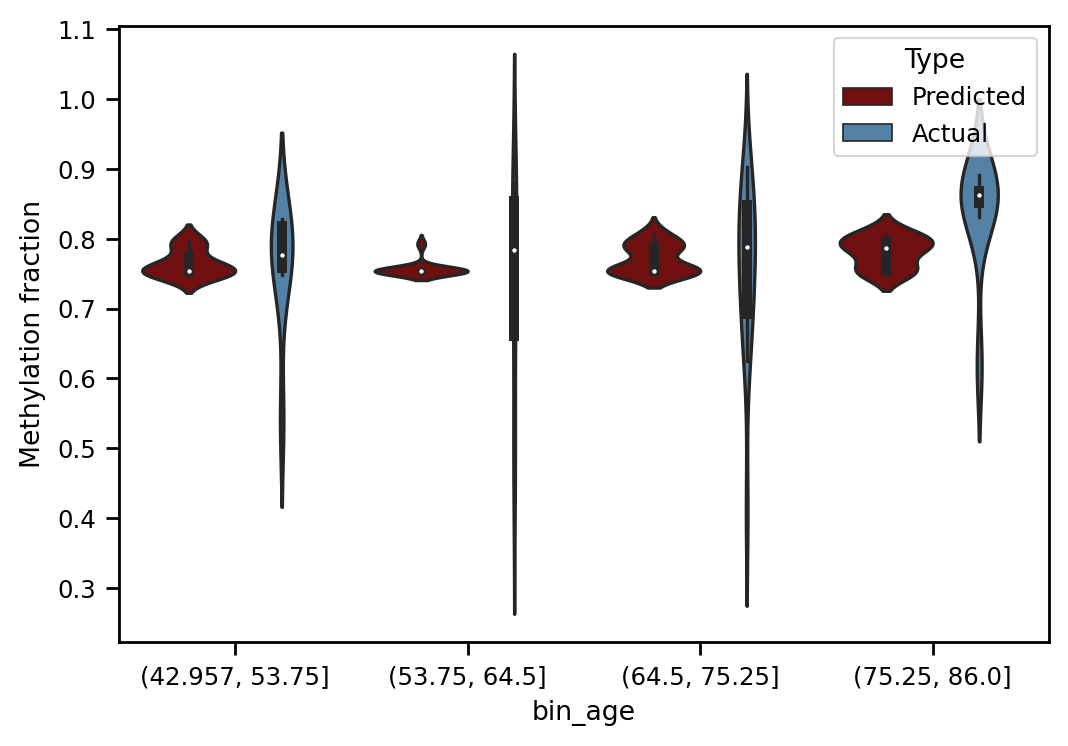

In [75]:
_ = somage_tcga_dict[0].plot_real_vs_predicted_methylation(
        cpg = "cg19130973",
        dataset = "STAD", 
        sample_set = "test",
        )

#### Feature importance

# ICGC Data

In [6]:
# qnorm 
icgc_mut_w_age_df, illumina_cpg_locs_df, icgc_methyl_age_df_t, icgc_matrix_qtl_dir, icgc_covariate_fn = get_data.read_icgc_data()

reading in data
Got mutations and metadata, reading methylation
Got methylation, transposing
Done


In [12]:
icgc_methyl_age_df_t.shape

(651, 326752)

In [11]:
icgc_mut_w_age_df

,case_submitter_id,chr,start,end,reference,alt,DNA_VAF,mutation,dataset,gender,dataset_r,gender_r,age_at_index
0,DO35009,16,10093626,10093626,C,A,0.136364,C>A,PACA,MALE,PACA,MALE,64
1,DO35009,10,6726330,6726330,G,C,0.275229,G>C,PACA,MALE,PACA,MALE,64
2,DO35009,10,107021254,107021254,C,A,0.432203,C>A,PACA,MALE,PACA,MALE,64
3,DO35009,1,26892465,26892465,A,G,0.176471,A>G,PACA,MALE,PACA,MALE,64
4,DO35009,8,96203326,96203326,A,T,0.275862,A>T,PACA,MALE,PACA,MALE,64
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3919284,DO229096,20,23691266,23691266,G,C,0.469388,G>C,UTCA,FEMALE,UTCA,FEMALE,65
3919285,DO229096,12,128689264,128689264,A,T,0.285714,A>T,UTCA,FEMALE,UTCA,FEMALE,65
3919286,DO229096,12,128689264,128689264,A,T,0.329114,A>T,UTCA,FEMALE,UTCA,FEMALE,65
3919287,DO229096,X,122587198,122587198,C,T,0.250000,C>T,UTCA,FEMALE,UTCA,FEMALE,65


In [10]:
icgc_methyl_age_df_t['dataset'].value_counts()

PRAD    241
PACA    161
OV       92
PBCA     72
CLLE     47
PAEN     22
UTCA     16
Name: dataset, dtype: int64

In [8]:
icgc_mut_w_age_df['case_submitter_id'].nunique()


KeyboardInterrupt



# testing methyl pred

In [4]:
motif_occurence_df = pd.read_parquet(
        "/cellar/users/zkoch/methylation_and_mutation/data/methylation_motifs_weiWang/motif_occurences/motif_occurences_combined_15kb.parquet"
        )

In [21]:
mut_feat_tcga = mutation_features.mutationFeatures(
        all_mut_w_age_df = all_mut_w_age_df, illumina_cpg_locs_df = illumina_cpg_locs_df, 
        all_methyl_age_df_t = all_methyl_age_df_t, out_dir = "./", 
        consortium = 'TCGA', dataset = '', cross_val_num = 0,
        matrix_qtl_dir = matrix_qtl_dir,
        covariate_fn = covariate_fn, motif_occurence_df = motif_occurence_df
    )

In [22]:
mut_feat_tcga.create_all_feat_mats(
    cpg_ids = ['cg20701897'], 
    aggregate = 'Both',
    num_correl_sites = 500, 
    max_meqtl_sites=0,
    nearby_window_size = 50000, 
    extend_amount = 500 
    )

Finished 0 of 1


In [6]:
# read in a mutation features store 
mut_store_dict = pd.read_pickle("/cellar/users/zkoch/methylation_and_mutation/output_dirs/071823_tcga_somage_output/TCGA__500correl_0meqtl_50000nearby_Bothagg_1000numCpGs_0startTopCpGs_500extendAmount_0crossValNum/TCGA__500correl_0meqtl_50000nearby_Bothagg_1000numCpGs_0startTopCpGs_500extendAmount_0crossValNum.features.pkl")

In [19]:
df_from_job = pd.DataFrame(mut_store_dict['feat_mats']['cg20701897'].todense(), columns = mut_store_dict['feat_names']['cg20701897'])

In [23]:
df_from_notebook = pd.DataFrame(mut_feat_tcga.mutation_features_store['feat_mats']['cg20701897'].todense(), columns = mut_feat_tcga.mutation_features_store['feat_names']['cg20701897'])

In [24]:
df_from_notebook[df_from_notebook.columns[df_from_notebook.columns.str.contains('agg')]].sum()

agg_pos_corr+          6.630005
agg_neg_corr+          4.779663
agg_pos_corr_ext+    524.618042
agg_neg_corr_ext+    452.069489
agg_nearby+          783.176697
agg_very_nearby+     116.592194
agg_mm_motif+          5.610016
agg_um_motif+          0.000000
dtype: float32

In [58]:
df.sum()

nearby+2:179561894      0.209961
nearby+2:179563573      0.059998
nearby+2:179563588      0.099976
nearby+2:179563606      0.370117
nearby+2:179563636      0.090027
                         ...    
dataset+THCA          488.000000
dataset+THYM          121.000000
dataset+UCEC          398.000000
dataset+UCS            57.000000
dataset+UVM            80.000000
Length: 3287, dtype: float32

In [53]:
df = pd.DataFrame(mut_feat_tcga.mutation_features_store['feat_mats']['cg20701897'].todense(), columns = mut_feat_tcga.mutation_features_store['feat_names']['cg20701897'])

In [15]:
methyl_pred = methylation_pred.methylationPrediction(
    mut_feat_store_fns = ["/cellar/users/zkoch/methylation_and_mutation/output_dirs/071823_tcga_somage_output/TCGA__500correl_0meqtl_50000nearby_Bothagg_1000numCpGs_0startTopCpGs_500extendAmount_0crossValNum/TCGA__500correl_0meqtl_50000nearby_Bothagg_1000numCpGs_0startTopCpGs_500extendAmount_0crossValNum.features.pkl"],
    model_type = "xgboost",
    baseline = "none",
    agg_only = True,
    scale_counts_within_dataset = False,
    predict_with_random_feat = -1,
    illumina_cpg_locs_df = illumina_cpg_locs_df,
    all_methyl_age_df_t = all_methyl_age_df_t,
    use_gpu = False
    )

Done reading /cellar/users/zkoch/methylation_and_mutation/output_dirs/071823_tcga_somage_output/TCGA__500correl_0meqtl_50000nearby_Bothagg_1000numCpGs_0startTopCpGs_500extendAmount_0crossValNum/TCGA__500correl_0meqtl_50000nearby_Bothagg_1000numCpGs_0startTopCpGs_500extendAmount_0crossValNum.features.pkl


In [42]:
methyl_pred.train_all_models(just_one = False)
#methyl_pred.apply_all_models(just_one = True)
#methyl_pred.calc_performance_by_dataset()

agg feature sums
agg_pos_corr+        0.0
agg_neg_corr+        0.0
agg_pos_corr_ext+    0.0
agg_neg_corr_ext+    0.0
agg_nearby+          0.0
agg_very_nearby+     0.0
agg_mm_motif+        0.0
agg_um_motif+        0.0
dtype: float32
OUTER: done training 0 CpGs of 1000
agg feature sums
agg_pos_corr+        0.0
agg_neg_corr+        0.0
agg_pos_corr_ext+    0.0
agg_neg_corr_ext+    0.0
agg_nearby+          0.0
agg_very_nearby+     0.0
agg_mm_motif+        0.0
agg_um_motif+        0.0
dtype: float32
agg feature sums
agg_pos_corr+        0.0
agg_neg_corr+        0.0
agg_pos_corr_ext+    0.0
agg_neg_corr_ext+    0.0
agg_nearby+          0.0
agg_very_nearby+     0.0
agg_mm_motif+        0.0
agg_um_motif+        0.0
dtype: float32
agg feature sums
agg_pos_corr+        0.0
agg_neg_corr+        0.0
agg_pos_corr_ext+    0.0
agg_neg_corr_ext+    0.0
agg_nearby+          0.0
agg_very_nearby+     0.0
agg_mm_motif+        0.0
agg_um_motif+        0.0
dtype: float32
agg feature sums
agg_pos_corr+      

In [23]:
methyl_pred_scramble = methylation_pred.methylationPrediction(
    mut_feat_store_fns = ["/cellar/users/zkoch/methylation_and_mutation/output_dirs/071823_tcga_somage_output/TCGA__500correl_0meqtl_50000nearby_Bothagg_1000numCpGs_0startTopCpGs_500extendAmount_0crossValNum/TCGA__500correl_0meqtl_50000nearby_Bothagg_1000numCpGs_0startTopCpGs_500extendAmount_0crossValNum.features.pkl"],
    model_type = "xgboost",
    baseline = "scramble",
    agg_only = True,
    scale_counts_within_dataset = False,
    predict_with_random_feat = -1,
    illumina_cpg_locs_df = illumina_cpg_locs_df,
    all_methyl_age_df_t = all_methyl_age_df_t,
    use_gpu = False
    )

Done reading /cellar/users/zkoch/methylation_and_mutation/output_dirs/071823_tcga_somage_output/TCGA__500correl_0meqtl_50000nearby_Bothagg_1000numCpGs_0startTopCpGs_500extendAmount_0crossValNum/TCGA__500correl_0meqtl_50000nearby_Bothagg_1000numCpGs_0startTopCpGs_500extendAmount_0crossValNum.features.pkl


In [39]:
methyl_pred_scramble.train_all_models(just_one = True)
#methyl_pred_scramble.apply_all_models(just_one = True)
#methyl_pred_scramble.calc_performance_by_dataset()

scrambling
before scrambling
3254    3149.0
3253    2928.0
3257     519.0
3276     409.0
3282     392.0
         ...  
1098       0.0
1099       0.0
1100       0.0
1101       0.0
1643       0.0
Length: 3287, dtype: float32
3253    gender+FEMALE
3254      gender+MALE
3255      dataset+ACC
3256     dataset+BLCA
3257     dataset+BRCA
3258     dataset+CESC
3259     dataset+CHOL
3260     dataset+COAD
3261     dataset+DLBC
3262     dataset+ESCA
3263      dataset+GBM
3264     dataset+HNSC
3265     dataset+KICH
3266     dataset+KIRC
3267     dataset+KIRP
3268     dataset+LAML
3269     dataset+LIHC
3270     dataset+LUAD
3271     dataset+LUSC
3272     dataset+MESO
3273       dataset+OV
3274     dataset+PAAD
3275     dataset+PCPG
3276     dataset+PRAD
3277     dataset+READ
3278     dataset+SARC
3279     dataset+SKCM
3280     dataset+STAD
3281     dataset+TGCT
3282     dataset+THCA
3283     dataset+THYM
3284     dataset+UCEC
3285      dataset+UCS
3286      dataset+UVM
dtype: object
3254    3149.0


,AvP_methyl_pearson,Pmethyl_v_Age_pearson_abs,train_AvP_methyl_pearson,train_Amethyl_v_Age_pearson_abs,dataset,cpg
0,-0.330673,0.061125,0.028316,0.041841,HNSC,cg20701897
1,-0.044626,0.211605,0.048890,0.156828,THCA,cg20701897
2,NaN,NaN,NaN,0.058500,PRAD,cg20701897
3,-0.019248,0.317847,0.073489,0.040737,SKCM,cg20701897
4,0.191358,0.053916,0.078447,0.117626,LUAD,cg20701897
5,NaN,NaN,NaN,0.115320,UCEC,cg20701897
6,-0.357796,0.225030,0.014127,0.038505,BLCA,cg20701897
7,-0.353059,0.101876,0.009143,0.011966,STAD,cg20701897
8,-0.307724,0.187289,0.024973,0.200761,LIHC,cg20701897
9,0.157638,0.016516,0.081086,0.100244,LUSC,cg20701897


# Feature importances

In [32]:
# for each of the best predicted CpGs 
cv_num = 0
top_cpgs = 50
dataset = 'UCEC'

top_cpgs_list = somage_tcga_dict[cv_num].performance_by_dataset_df.query('dataset == @dataset').sort_values(
    by = 'AvP_methyl_spearman', ascending = False
    ).head(top_cpgs)['cpg']

all_feat_imp_dfs = []
all_feat_imp_by_cat_dfs = []
for cpg in top_cpgs_list:
    # get the model and feature names
    model, feat_names, train_mat, test_mat = (
        somage_tcga_dict[cv_num]
        .get_model_feat_names_train_test(cpg, dataset = dataset)
        )
    feat_imp_df, feat_imp_by_cat_df = somage_tcga_dict[cv_num].get_one_cpg_feat_score_by_cat(
        model, feat_names, train_mat, test_mat, 
        importance_calculator = 'shap', importance_type = "gain"
        )
    feat_imp_df['cpg'] = cpg
    feat_imp_by_cat_df['cpg'] = cpg
    all_feat_imp_dfs.append(feat_imp_df)
    all_feat_imp_by_cat_dfs.append(feat_imp_by_cat_df)
    
all_feat_imp_df = pd.concat(all_feat_imp_dfs).drop_duplicates()
all_feat_imp_by_cat_df = pd.concat(all_feat_imp_by_cat_dfs).drop_duplicates()
all_feat_imp_by_cat_df.rename(columns = {'category': 'Feature type'}, inplace = True)

all_feat_imp_by_cat_df['Feature type'] = all_feat_imp_by_cat_df['Feature type'].map({
    'Nearby locus': 'Specific loci (<50kb distance)',
    'dataset':'Tissue type',
    'matrixqtl_neg_beta': 'Aggregated - somatic-meQTLS', 
    'matrixqtl_pos_beta': 'Aggregated + somatic-meQTLS', 
    'matrixqtl_neg_beta_close': 'Aggregated - somatic-meQTLS (<50kb distance)', 
    'matrixqtl_pos_beta_close': 'Aggregated + somatic-meQTLS (<50kb distance)', 
    'matrixqtl_neg_beta_close_ext': 'Aggregated - somatic-meQTLS (<50kb distance, extended', 
    'matrixqtl_pos_beta_close_ext': 'Aggregated + somatic-meQTLS (<50kb distance, extended)', 
    'nearby': 'Aggregated nearby loci (<50kb distance)',
    'neg_corr': 'Aggregated negatively correlated CpGs',
    'pos_corr': 'Aggregated positively correlated CpGs',
    'pos_corr_ext': 'Aggregated positively correlated CpGs (extended)',
    'neg_corr_ext': 'Aggregated negatively correlated CpGs (extended)',
    'specific_corr_ext': 'Specific correlated CpG (extended)',
    'specific_nested': 'Specific nested feature',
    'specific_tesselated': 'Specific tesselated feature',
    'very_nearby': 'Specific loci (<1kb distance)',
    'specific_neg_beta_close_ext': 'Specific - somatic-meQTLS (<50kb distance, extended)',
    'specific_neg_beta_ext': 'Specific - somatic-meQTLS (extended)',
    'specific_pos_beta_close_ext': 'Specific + somatic-meQTLS (<50kb distance, extended)',
    'specific_pos_beta_ext': 'Specific + somatic-meQTLS (extended)',
})


 98%|===================| 1485/1523 [00:11<00:00]        

# Co-localization soMage

### Development

In [ ]:
motif_occurence_df = pd.read_parquet(
        "/cellar/users/zkoch/methylation_and_mutation/data/methylation_motifs_weiWang/motif_occurences/motif_occurences_combined_15kb.parquet"
        )
mut_feat_icgc = mutation_features.mutationFeatures(
        all_mut_w_age_df = icgc_mut_w_age_df, illumina_cpg_locs_df = illumina_cpg_locs_df, 
        all_methyl_age_df_t = icgc_methyl_age_df_t, out_dir = "./", 
        consortium = 'ICGC', dataset = '', cross_val_num = 0,
        matrix_qtl_dir = icgc_matrix_qtl_dir,
        covariate_fn = icgc_covariate_fn, motif_occurence_df = motif_occurence_df
    )

In [10]:
mut_feat_params = {
    'aggregate': 'Both',
    'num_correl_sites': 500,
    'max_meqtl_sites': 0,
    'nearby_window_size': 50000,
    'extend_amount': 500
}

mut_feat_icgc.create_all_feat_mats(
    cpg_ids = icgc_methyl_age_df_t.columns[5:10].tolist(), 
    aggregate = mut_feat_params['aggregate'],
    num_correl_sites = mut_feat_params['num_correl_sites'], 
    max_meqtl_sites=mut_feat_params['max_meqtl_sites'],
    nearby_window_size = mut_feat_params['nearby_window_size'], 
    extend_amount = mut_feat_params['extend_amount'] 
    )

Finished 0 of 5


In [71]:
methyl_pred = methylation_pred.methylationPrediction(
                mut_feat_store = mut_feat_icgc.mutation_features_store,
                #mut_feat_store_fns = mut_feat_store_fns,
                model_type = "xgboost",
                baseline = "none",
                agg_only = True,
                scale_counts_within_dataset = True,
                predict_with_random_feat = 2,
                illumina_cpg_locs_df = illumina_cpg_locs_df,
                )
methyl_pred.train_all_models()
methyl_pred.apply_all_models()
methyl_pred.save_models_and_preds(out_dir = "/cellar/users/zkoch/methylation_and_mutation/test_out")

['cg00000289', 'cg00000622', 'cg00000165', 'cg00000292']
INNER: done training 0 CpGs of 3
OUTER: done training 0 CpGs of 5
['cg00000622', 'cg00000289', 'cg00000109', 'cg00000292']
INNER: done training 0 CpGs of 3
['cg00000622', 'cg00000109', 'cg00000165', 'cg00000292']
INNER: done training 0 CpGs of 3
['cg00000622', 'cg00000109', 'cg00000165', 'cg00000289']
INNER: done training 0 CpGs of 3
['cg00000289', 'cg00000109', 'cg00000165', 'cg00000292']
INNER: done training 0 CpGs of 3
Predicted methylation for 0 CpGs of 15
Predicted methylation for 10 CpGs of 15
wrote out trained models and predictions to /cellar/users/zkoch/methylation_and_mutation/test_out


### Results

In [4]:
mut_feat_tcga_coloc_dict = {}
somage_tcga_coloc_dict = {}

# for each cv iteration
for cv_num in [0]:
    # create a mutation features object
    mut_feat_tcga = mutation_features.mutationFeatures(
        all_mut_w_age_df = all_mut_w_age_df, illumina_cpg_locs_df = illumina_cpg_locs_df, 
        all_methyl_age_df_t = all_methyl_age_df_t, out_dir = "./", 
        consortium = 'TCGA', dataset = '', cross_val_num = cv_num,
        matrix_qtl_dir = matrix_qtl_dir,
        covariate_fn = covariate_fn, motif_occurence_df = pd.DataFrame()
    )
    # add to dictionary
    mut_feat_tcga_coloc_dict[cv_num] = mut_feat_tcga
    # and create a somage object from the seperate somage outputs
    somage_tcga = somatic_mut_clock.mutationClock.construct_from_paths(
        somage_path = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/062623_tcga_somage_output",
        directory_glob = f"TCGA__500correl_0meqtl_50000nearby_Bothagg_500numCpGs_0startTopCpGs_500extendAmount_{cv_num}crossValNum",
        file_suffix = "xgboost_nonebaseline_agg_only_predict_with_random_feat_100",
        mut_feat = mut_feat_tcga,
        illumina_cpg_locs_df = illumina_cpg_locs_df,
        all_methyl_age_df_t = all_methyl_age_df_t,
        out_dir = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/062623_tcga_somage_output"
        )
    # read in pre-comp prediction performance by dset
    # somage_tcga.performance_by_dataset_df = pd.read_parquet(f"/cellar/users/zkoch/methylation_and_mutation/output_dirs/051723_tcga_somage_output/pred_methyl_and_perf_by_dset/performance_by_dataset_CV{cv_num}.parquet")
    # add to dictionary
    somage_tcga_coloc_dict[cv_num] = somage_tcga

Creating soMage object


The least populated class in y has only 2 members, which is less than n_splits=5.


In [56]:
somage_tcga_coloc_dict[cv_num].performance_by_dataset(predicted_with_random_feat = True)

['HNSC', 'THCA', 'PRAD', 'SKCM', 'LUAD', 'UCEC', 'BLCA', 'STAD', 'LIHC', 'LUSC', 'KIRC', 'CESC', 'COAD', 'KIRP', 'SARC', 'PAAD', 'ESCA']
done with dataset: HNSC
done with dataset: THCA
done with dataset: PRAD
done with dataset: SKCM
done with dataset: LUAD
done with dataset: UCEC
done with dataset: BLCA
done with dataset: STAD
done with dataset: LIHC
done with dataset: LUSC
done with dataset: KIRC
done with dataset: CESC
done with dataset: COAD
done with dataset: KIRP
done with dataset: SARC
done with dataset: PAAD
done with dataset: ESCA


In [57]:
somage_tcga_coloc_dict[cv_num].performance_by_dataset_df

,AvP_methyl_pearson,Pmethyl_v_Age_pearson_abs,train_AvP_methyl_pearson,train_Amethyl_v_Age_pearson_abs,dataset,cpg,self_pred
0,0.338562,0.000858,0.524399,0.051693,HNSC,target_cg20701897_train_cg10792831,False
1,0.408807,0.041500,0.480743,0.051693,HNSC,target_cg20701897_train_cg06587969,False
2,0.334889,0.071905,0.398912,0.051693,HNSC,target_cg20701897_train_cg27614485,False
3,0.245985,0.073724,0.420004,0.051693,HNSC,target_cg20701897_train_cg07899016,False
4,0.255083,0.060506,0.406879,0.051693,HNSC,target_cg20701897_train_cg26394771,False
...,...,...,...,...,...,...,...
858495,0.104329,0.273202,0.245530,0.093157,ESCA,target_cg22153481_train_cg23211470,False
858496,-0.022468,0.058995,0.299766,0.093157,ESCA,target_cg22153481_train_cg07745166,False
858497,-0.052697,0.246424,0.414726,0.093157,ESCA,target_cg22153481_train_cg20978937,False
858498,-0.103136,0.028512,0.824083,0.093157,ESCA,target_cg22153481_train_cg18198734,False


<Axes: xlabel='self_pred', ylabel='Pmethyl_v_Age_pearson_abs'>

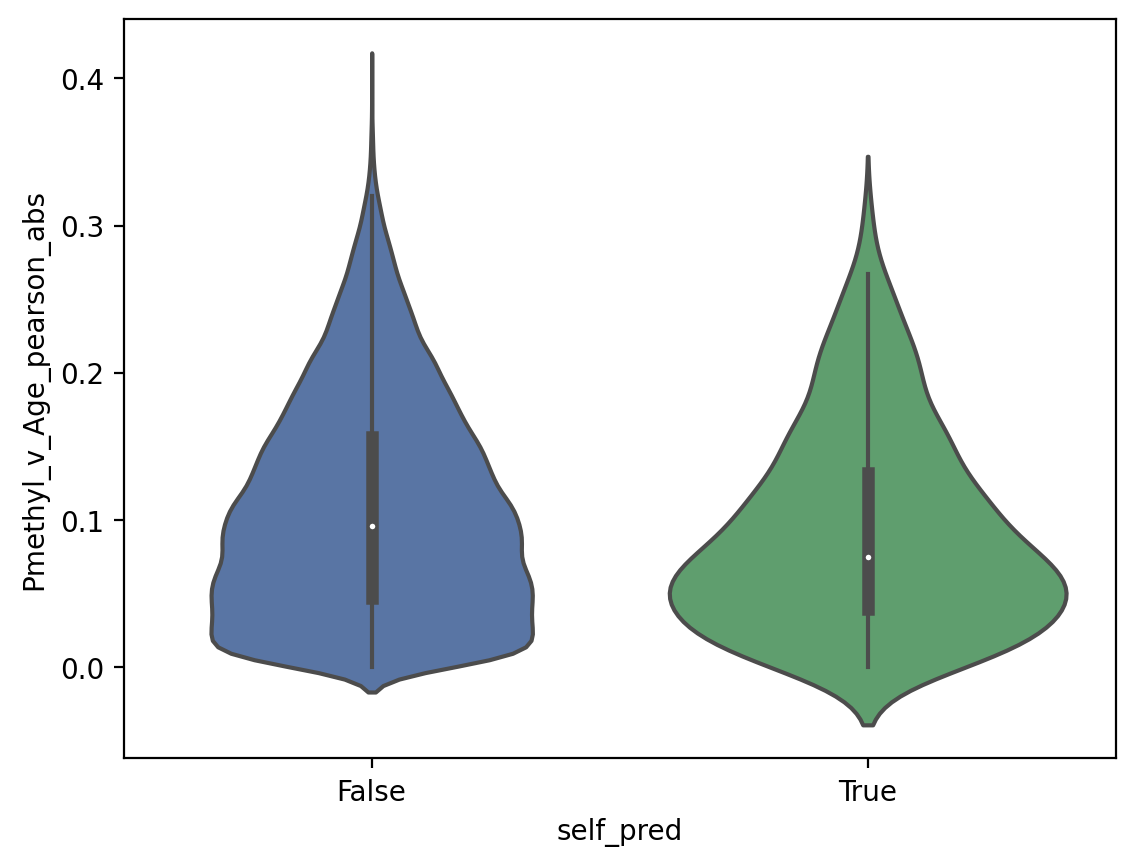

In [53]:
sns.violinplot(data = somage_tcga_coloc_dict[cv_num].performance_by_dataset_df, x = 'self_pred', y = 'Pmethyl_v_Age_pearson_abs')

In [58]:
somage_tcga_coloc_dict[cv_num].performance_by_dataset_df.groupby('self_pred')['AvP_methyl_pearson'].describe()

,count,mean,std,min,25%,50%,75%,max
self_pred,,,,,,,,
False,849826.0,0.059692,0.153961,-0.884854,-0.044407,0.051556,0.156399,0.894498
True,8499.0,0.062402,0.151453,-0.614081,-0.042173,0.052585,0.162818,0.874195


<Axes: xlabel='AvP_methyl_pearson', ylabel='Probability'>

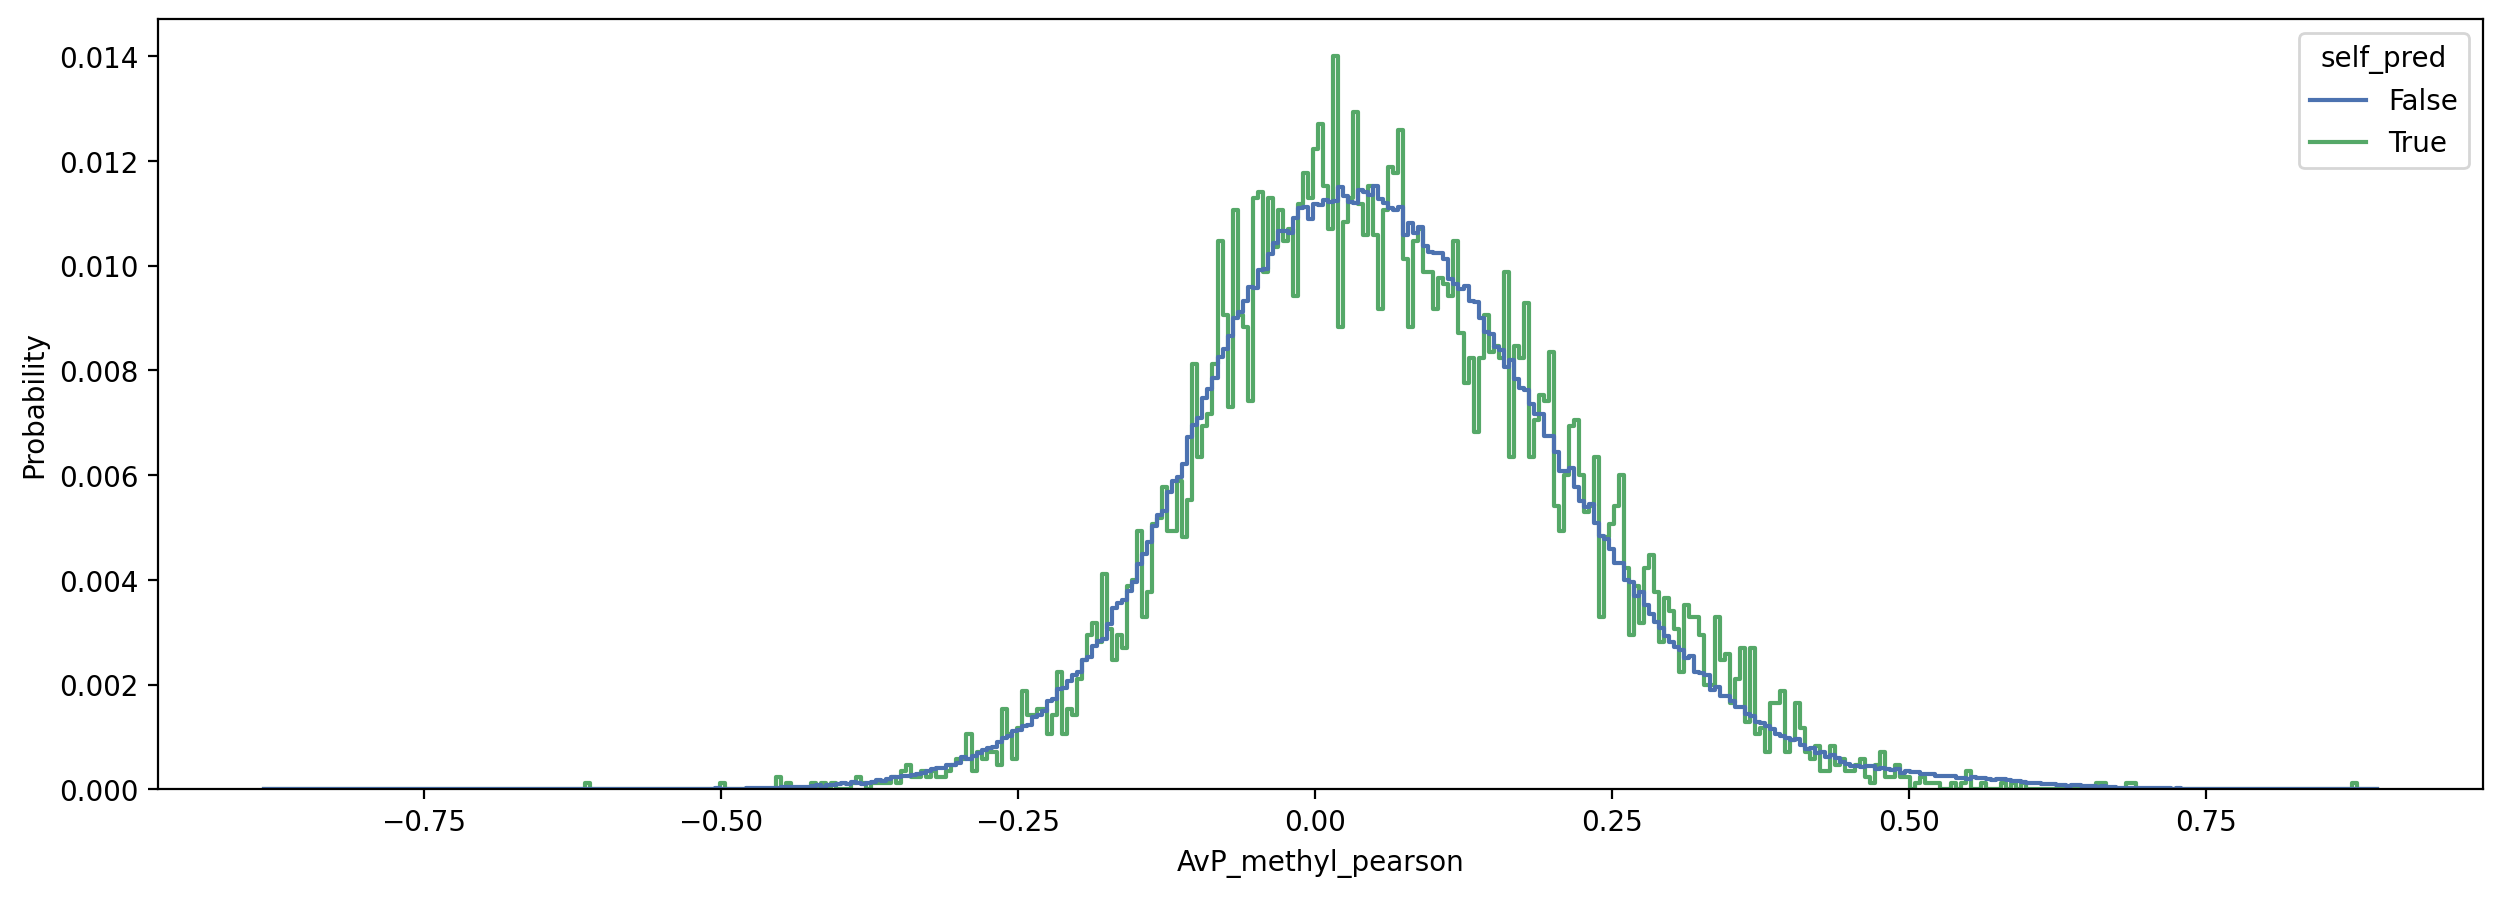

In [70]:
plt.figure(figsize = (15, 5))
sns.histplot(data = somage_tcga_coloc_dict[cv_num].performance_by_dataset_df, x = 'AvP_methyl_pearson', hue = 'self_pred', stat='probability',  common_norm=False, element="step", fill=False)

In [5]:
somage_tcga_coloc_dict[0].predicted_methyl_df

,target_cg20701897_train_cg10792831,target_cg20701897_train_cg06587969,target_cg20701897_train_cg27614485,target_cg20701897_train_cg07899016,target_cg20701897_train_cg26394771,target_cg20701897_train_cg15613340,target_cg20701897_train_cg04503600,target_cg20701897_train_cg24954590,target_cg20701897_train_cg00141260,target_cg20701897_train_cg13307880,...,target_cg22153481_train_cg16263180,target_cg22153481_train_cg19906284,target_cg22153481_train_cg21548029,target_cg22153481_train_cg20649716,target_cg22153481_train_cg27394566,target_cg22153481_train_cg23211470,target_cg22153481_train_cg07745166,target_cg22153481_train_cg20978937,target_cg22153481_train_cg18198734,target_cg22153481_train_cg22153481
TCGA-VP-A87J,0.868585,0.868014,0.865742,0.865288,0.865727,0.865516,0.865194,0.864323,0.865933,0.864571,...,0.026619,0.026308,0.026667,0.026478,0.026433,0.026564,0.026573,0.026498,0.026236,0.026417
TCGA-D9-A1JX,0.673732,0.690915,0.671275,0.654029,0.667233,0.666458,0.672496,0.663781,0.626165,0.677492,...,0.027362,0.027249,0.026881,0.026582,0.027353,0.026776,0.028046,0.026975,0.027181,0.027425
TCGA-T2-A6WZ,0.735863,0.661124,0.755905,0.757551,0.765472,0.766428,0.752454,0.759671,0.762627,0.763636,...,0.031403,0.031651,0.030937,0.031421,0.030533,0.031338,0.031276,0.030530,0.026657,0.030968
TCGA-L5-A4OE,0.729821,0.744536,0.708497,0.746974,0.679157,0.719245,0.686129,0.707752,0.687898,0.725771,...,0.030518,0.031836,0.031866,0.029704,0.028480,0.033364,0.032720,0.028190,0.028522,0.031288
TCGA-OU-A5PI,0.786225,0.802178,0.789802,0.785325,0.795196,0.785027,0.786085,0.790074,0.784198,0.796295,...,0.024537,0.024406,0.024718,0.025853,0.024934,0.025314,0.024436,0.025160,0.024338,0.024581
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-HC-A6AN,0.868585,0.868014,0.865742,0.865288,0.865727,0.865516,0.865194,0.864323,0.865933,0.864571,...,0.026619,0.026308,0.026667,0.026478,0.026433,0.026564,0.026573,0.026498,0.026447,0.026417
TCGA-DD-AACJ,0.639589,0.664630,0.681329,0.678557,0.674892,0.677644,0.680421,0.674391,0.666559,0.682303,...,0.026594,0.026317,0.027257,0.027172,0.026739,0.027307,0.026825,0.026600,0.026437,0.026456
TCGA-B5-A3FD,0.701303,0.739932,0.781435,0.778948,0.779621,0.777743,0.776312,0.774973,0.781164,0.777186,...,0.031262,0.028377,0.030916,0.030566,0.029747,0.031647,0.031265,0.029191,0.028208,0.030577
TCGA-MH-A55W,0.754739,0.752199,0.752385,0.752828,0.751088,0.754156,0.751673,0.751505,0.745946,0.753790,...,0.030155,0.029173,0.029594,0.029560,0.029521,0.029458,0.028842,0.029439,0.028314,0.028956


# Feature creation, with/without GPU

#### TCGA testing JIT

In [7]:
motif_occurence_df = pd.read_parquet(
        "/cellar/users/zkoch/methylation_and_mutation/data/methylation_motifs_weiWang/motif_occurences/motif_occurences_combined_15kb.parquet"
        )

In [42]:
mut_feat_tcga = mutation_features.mutationFeatures(
            all_mut_w_age_df = all_mut_w_age_df, illumina_cpg_locs_df = illumina_cpg_locs_df, 
            all_methyl_age_df_t = all_methyl_age_df_t, out_dir = "./", 
            consortium = 'TCGA', dataset = '', cross_val_num = 0,
            matrix_qtl_dir = matrix_qtl_dir,
            covariate_fn = covariate_fn, motif_occurence_df = motif_occurence_df
        )

In [58]:
mut_feat_params = {
        'bin_size': 25000, 'aggregate': 'Both', 
        'num_correl_sites' : 500, 'max_meqtl_sites' : 0,
        'nearby_window_size' : 50000, 'extend_amount' : 500
    }
mut_feat_tcga.create_all_feat_mats(
    cpg_ids = all_methyl_age_df_t.columns[3:6].tolist(), 
    aggregate = mut_feat_params['aggregate'],
    num_correl_sites = mut_feat_params['num_correl_sites'], 
    max_meqtl_sites=mut_feat_params['max_meqtl_sites'],
    nearby_window_size = mut_feat_params['nearby_window_size'], 
    extend_amount = mut_feat_params['extend_amount'] 
    )
# 2 min for 3 cpgs
# 1:46 for 3 cpgs
# 2:35 for 5 new way
# 2:56 for 5 old corr way

Finished 0 of 3


In [ ]:
# each takes 10 hours
# 273 jobs => 2730 hours => 114 days


In [59]:
mut_feat_store_fn = mut_feat_tcga.save_mutation_features(
    start_top_cpgs = 3
    )

Saved mutation features to
./TCGA__500correl_0meqtl_50000nearby_Bothagg_8numCpGs_3startTopCpGs_500extendAmount_0crossValNum/TCGA__500correl_0meqtl_50000nearby_Bothagg_8numCpGs_3startTopCpGs_500extendAmount_0crossValNum.features.pkl
